# Library Imports

In [2]:
import pandas as pd
import glob
import requests
import time

In [112]:
import seaborn as sns

# Data Imports / Exports

In [35]:
# THESE FILES ARE EXCLUDED FROM THE REPOSITORY
stream_json = glob.glob('datasets/Streaming_History_Audio*.json')

In [36]:
# see the list of globbed files
stream_json

['datasets\\Streaming_History_Audio_2016-2017_0.json',
 'datasets\\Streaming_History_Audio_2017-2018_1.json',
 'datasets\\Streaming_History_Audio_2018-2019_2.json',
 'datasets\\Streaming_History_Audio_2019-2020_3.json',
 'datasets\\Streaming_History_Audio_2020-2021_4.json',
 'datasets\\Streaming_History_Audio_2021-2022_5.json',
 'datasets\\Streaming_History_Audio_2022-2023_6.json',
 'datasets\\Streaming_History_Audio_2023_7.json',
 'datasets\\Streaming_History_Audio_2023_8.json']

In [40]:
# load the globbed files into a dataframe
stream_df = pd.concat([pd.read_json(f) for f in stream_json])

In [3]:
tracks_df = pd.read_csv('datasets/tracks_df.csv')
podcasts_df = pd.read_csv('datasets/podcasts_df.csv')

C:\Users\Kim\AppData\Local\Temp\ipykernel_20844\2056156176.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  tracks_df = pd.read_csv('datasets/tracks_df.csv')


# Preparing for Data Collection
we need 4 things here.
1. tracks streaming history
2. podcasts streaming history
3. list of unique tracks streamed
4. ~~list of unique podcasts streamed~~ not really needed actually

In [41]:
print(stream_df.shape)
print(stream_df.columns)

(128775, 21)
Index(['ts', 'username', 'platform', 'ms_played', 'conn_country',
       'ip_addr_decrypted', 'user_agent_decrypted',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'reason_start',
       'reason_end', 'shuffle', 'skipped', 'offline', 'offline_timestamp',
       'incognito_mode'],
      dtype='object')


In [42]:
stream_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128775 entries, 0 to 1545
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   ts                                 128775 non-null  object
 1   username                           128775 non-null  object
 2   platform                           128775 non-null  object
 3   ms_played                          128775 non-null  int64 
 4   conn_country                       128775 non-null  object
 5   ip_addr_decrypted                  108167 non-null  object
 6   user_agent_decrypted               108167 non-null  object
 7   master_metadata_track_name         127961 non-null  object
 8   master_metadata_album_artist_name  127961 non-null  object
 9   master_metadata_album_album_name   127961 non-null  object
 10  spotify_track_uri                  127961 non-null  object
 11  episode_name                       639 non-null     object


In [43]:
# number of unique values in each column
stream_df.nunique()

ts                                   121283
username                                  1
platform                                 33
ms_played                             26836
conn_country                              9
ip_addr_decrypted                      2737
user_agent_decrypted                      6
master_metadata_track_name             4714
master_metadata_album_artist_name      1639
master_metadata_album_album_name       2680
spotify_track_uri                      5172
episode_name                            295
episode_show_name                        31
spotify_episode_uri                     295
reason_start                              8
reason_end                               10
shuffle                                   2
skipped                                   2
offline                                   2
offline_timestamp                    126902
incognito_mode                            2
dtype: int64

In [44]:
stream_df.isna().sum()

ts                                        0
username                                  0
platform                                  0
ms_played                                 0
conn_country                              0
ip_addr_decrypted                     20608
user_agent_decrypted                  20608
master_metadata_track_name              814
master_metadata_album_artist_name       814
master_metadata_album_album_name        814
spotify_track_uri                       814
episode_name                         128136
episode_show_name                    128136
spotify_episode_uri                  128136
reason_start                              0
reason_end                            20608
shuffle                                   0
skipped                              106195
offline                                   0
offline_timestamp                         0
incognito_mode                            0
dtype: int64

In [45]:
stream_df['user_agent_decrypted'].value_counts()

user_agent_decrypted
unknown                                                                                                                                                                  108091
Mozilla%2F5.0%20(Windows%20NT%2010.0;%20Win64;%20x64)%20AppleWebKit%2F537.36%20(KHTML,%20like%20Gecko)%20Chrome%2F95.0.4638.54%20Safari%2F537.36%20Edg%2F95.0.1020.40        66
Mozilla%2F5.0%20(Windows%20NT%2010.0;%20Win64;%20x64;%20rv:84.0)%20Gecko%2F20100101%20Firefox%2F84.0                                                                          6
Mozilla%2F5.0%20(Windows%20NT%2010.0;%20Win64;%20x64;%20rv:61.0)%20Gecko%2F20100101%20Firefox%2F61.0                                                                          2
Mozilla%2F5.0%20(Windows%20NT%2010.0;%20Win64;%20x64;%20rv:69.0)%20Gecko%2F20100101%20Firefox%2F69.0                                                                          1
Mozilla%2F5.0%20(Windows%20NT%2010.0;%20Win64;%20x64;%20rv:83.0)%20Gecko%2F20100101%20Firefox%2F83.

In [46]:
# dropping some columns that might cnotain sensitive information or just not useful
stream_df.drop(columns=['username', 'ip_addr_decrypted', 'user_agent_decrypted'], inplace=True)

there are a huge number of null value of 'spotify_episode_uri', indicating that tracks/songs and podcasts don't share same uri, we need to separate this into its own dataframe (for tracks and podcasts)

In [55]:
# rows with null in both spotify_track_uri and spotify_episode_uri
print(stream_df[stream_df['spotify_episode_uri'].isna() & stream_df['spotify_track_uri'].isna()].shape)
print(stream_df[stream_df['spotify_episode_uri'].notna() & stream_df['spotify_track_uri'].notna()].shape)

(175, 18)
(0, 18)


so apparently there exists some rows are null on both spotify_episode_uri and spotify_track_uri, so those should be excluded as well

In [56]:
# get rows with null values in 'spotify_episode_uri' column and put it into a new dataframe
tracks_df = stream_df[stream_df['spotify_track_uri'].notna()]
podcasts_df = stream_df[stream_df['spotify_episode_uri'].notna()]

In [4]:
print(tracks_df.shape)
print(podcasts_df.shape)

(127961, 18)
(639, 18)


In [5]:
# list of tracks, containing unique values in 'spotify_track_uri' column
tracks_uri_list = tracks_df['spotify_track_uri'].unique().tolist()
podcasts_uri_list = podcasts_df['spotify_episode_uri'].unique().tolist()

In [59]:
print(len(tracks_uri_list))
print(len(podcasts_uri_list))

5172
295


In [60]:
# save tracks_df and podcasts_df into csv
tracks_df.to_csv('datasets/tracks_df.csv', index=False)
podcasts_df.to_csv('datasets/podcasts_df.csv', index=False)

# Data Collection (Spotipy)
now we're going to collect the using [Spotipy](https://spotipy.readthedocs.io/en/2.22.1/), it'll require user credentials (client_id and client_secret) which you can get [here](https://developer.spotify.com/dashboard) by registering your app at the dashboard

In [6]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [7]:
# Spotify API credentials (client_id and client_secret used will be excluded from the repository)
client_id = '7ba18f5bf5a947508d0354a128f17ad8'
client_secret = '0209cd1fc99a42dc887d14b9b4586843'

In [8]:
#Authentication - without user
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

## get track info

In [9]:
# since they have the batch request limit of 50, we need to split the list into batches of 50
track_info = {}
for i in range(0, len(tracks_uri_list), 50):
    track_batch = tracks_uri_list[i:i+50]
    sapi = sp.tracks(track_batch)
    for track in sapi['tracks']:
        track_info[track['id']] = {'name':track['name'], 'artistName':track['artists'][0]['name'], 'release_date':track['album']['release_date'], 'popularity':track['popularity'], 'duration_ms':track['duration_ms']}
    time.sleep(1)
    

In [10]:
len(track_info)

5172

In [11]:
list(track_info.items())[:5]

[('6tAM5c0bJOwRqGAEgiNMpI',
  {'name': 'Solace Album Mix',
   'artistName': 'Monstercat',
   'release_date': '2012-06-06',
   'popularity': 0,
   'duration_ms': 3538579}),
 ('4mjgNE8R31AzxWfPNGtVMf',
  {'name': 'Best of 2015 (Album Mix)',
   'artistName': 'Monstercat',
   'release_date': '2016-01-22',
   'popularity': 0,
   'duration_ms': 9158194}),
 ('5Q0P0cX3e42PgKd8LLS3ms',
  {'name': 'Horizon Album Mix',
   'artistName': 'Monstercat',
   'release_date': '2014-08-06',
   'popularity': 0,
   'duration_ms': 3623121}),
 ('6jvMmRtSzoEibQGrQkSISQ',
  {'name': 'Monstercat Best of 2012',
   'artistName': 'Monstercat',
   'release_date': '2013-02-04',
   'popularity': 0,
   'duration_ms': 6348017}),
 ('1KzLyjpjIRHuuj4iX8QsC2',
  {'name': 'Monstercat Podcast EP. 100',
   'artistName': 'Monstercat',
   'release_date': '2016-04-05',
   'popularity': 0,
   'duration_ms': 9744610})]

In [12]:
track_info_df = pd.DataFrame.from_dict(track_info, orient='index')

In [13]:
track_info_df.to_csv('datasets/tracks_info_df.csv')

## get track features

In [14]:
track_features = {}
for i in range(0, len(tracks_uri_list), 50):
    track_batch = tracks_uri_list[i:i+50]
    sapi = sp.audio_features(track_batch)
    for track in sapi:
        if track is not None:
            track_features[track['id']] = {'danceability':track['danceability'], 'energy':track['energy'], 'key':track['key'], 'loudness':track['loudness'], 'mode':track['mode'], 'speechiness':track['speechiness'], 'acousticness':track['acousticness'], 'instrumentalness':track['instrumentalness'], 'liveness':track['liveness'], 'valence':track['valence'], 'tempo':track['tempo'], 'time_signature':track['time_signature']}
        # we'll skip it if the track has no audio features data
    time.sleep(1)

In [15]:
len(track_features)

5165

In [16]:
# get first 5 items in the dictionary
list(track_features.items())[:5]

[('6tAM5c0bJOwRqGAEgiNMpI',
  {'danceability': 0.446,
   'energy': 0.823,
   'key': 11,
   'loudness': -5.279,
   'mode': 0,
   'speechiness': 0.0859,
   'acousticness': 0.00256,
   'instrumentalness': 0.0748,
   'liveness': 0.117,
   'valence': 0.263,
   'tempo': 128.198,
   'time_signature': 4}),
 ('5Q0P0cX3e42PgKd8LLS3ms',
  {'danceability': 0.402,
   'energy': 0.856,
   'key': 1,
   'loudness': -4.256,
   'mode': 1,
   'speechiness': 0.0659,
   'acousticness': 0.00504,
   'instrumentalness': 0.0164,
   'liveness': 0.253,
   'valence': 0.247,
   'tempo': 140.028,
   'time_signature': 4}),
 ('4VrdksXJVhAOLW49qV0VTQ',
  {'danceability': 0.426,
   'energy': 0.915,
   'key': 11,
   'loudness': -3.881,
   'mode': 0,
   'speechiness': 0.143,
   'acousticness': 0.000899,
   'instrumentalness': 0.108,
   'liveness': 0.495,
   'valence': 0.271,
   'tempo': 130.405,
   'time_signature': 4}),
 ('0ng42pTjKgskmobNzhnEUa',
  {'danceability': 0.434,
   'energy': 0.839,
   'key': 8,
   'loudness': 

In [17]:
track_features_df = pd.DataFrame.from_dict(track_features, orient='index')
track_features_df.to_csv('datasets/tracks_features_df.csv')

# Tracks Streaming Data

## Data Exploration / EDA

In [172]:
# let's load the tracks_df again
tracks_df = pd.read_csv('datasets/tracks_df.csv')
tracks_df.sample(5)

C:\Users\Kim\AppData\Local\Temp\ipykernel_14320\4189168743.py:2: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  tracks_df = pd.read_csv('datasets/tracks_df.csv')


,ts,platform,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
116162,2023-05-02T03:58:50Z,android,267300,JP,Sick of Losing Soulmates,dodie,Intertwined - EP,spotify:track:7a9udNo0GU97xnMAkjLdmE,NaN,NaN,NaN,trackdone,trackdone,True,False,False,1682999662,False
95640,2022-05-30T08:35:40Z,"Android OS 11 API 30 (OnePlus, HD1910)",5048,JP,おもかげ (produced by Vaundy),milet,おもかげ (produced by Vaundy),spotify:track:6ts1KCOudfDYXYfyWtq0k1,NaN,NaN,NaN,trackdone,backbtn,False,NaN,False,1653899732733,False
3438,2017-03-26T21:06:11Z,Windows 10 (10.0.10586; x64),178124,ID,"Swordland (From ""Sword Art Online"")",Taylor Davis,"Swordland (From ""Sword Art Online"")",spotify:track:1IbqahgWSIgMcgUxbupT19,NaN,NaN,NaN,trackdone,NaN,False,NaN,False,1490562191806,False
35760,2018-12-12T08:00:55Z,Windows 10 (10.0.17134; x64),198693,JP,Dream - Acoustic,Bishop Briggs,Dream,spotify:track:67l1tytshju3Ily8uIAVKH,NaN,NaN,NaN,trackdone,trackdone,True,NaN,False,1544601453776,False
55510,2020-02-03T10:00:36Z,Windows 10 (10.0.18362; x64; AppX),189346,JP,Wild Horses,Bishop Briggs,Bishop Briggs,spotify:track:0XyeD5XgusMHQlEVlUfxSn,NaN,NaN,NaN,trackdone,trackdone,True,NaN,False,1580723846279,False


In [173]:
print(tracks_df.shape)
print(tracks_df.columns)

(127961, 18)
Index(['ts', 'platform', 'ms_played', 'conn_country',
       'master_metadata_track_name', 'master_metadata_album_artist_name',
       'master_metadata_album_album_name', 'spotify_track_uri', 'episode_name',
       'episode_show_name', 'spotify_episode_uri', 'reason_start',
       'reason_end', 'shuffle', 'skipped', 'offline', 'offline_timestamp',
       'incognito_mode'],
      dtype='object')


In [174]:
# let's take a look at the tracks_df again
tracks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127961 entries, 0 to 127960
Data columns (total 18 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   ts                                 127961 non-null  object 
 1   platform                           127961 non-null  object 
 2   ms_played                          127961 non-null  int64  
 3   conn_country                       127961 non-null  object 
 4   master_metadata_track_name         127961 non-null  object 
 5   master_metadata_album_artist_name  127961 non-null  object 
 6   master_metadata_album_album_name   127961 non-null  object 
 7   spotify_track_uri                  127961 non-null  object 
 8   episode_name                       0 non-null       float64
 9   episode_show_name                  0 non-null       float64
 10  spotify_episode_uri                0 non-null       float64
 11  reason_start                       1279

Columns description
- ts : timestamp played
- ms_played : duration the track is played (ms)
- conn_country : country where the track was played
- master_metadata_track_name / artist_name / album_name : self explained
- spotify_track_uri : unique identifier for each track
- episode_name, episode_show_name, spotify_episode_uri : columns used for podcasts-related rows, might need to remove this later
- reason_start / end : a value telling why track is played
- shuffle / skipped / offline / incognito_mode : value whether the track if shuffle mode is used when the track is played, track skipped or when the track is played in offline mode or incognito_mode
- offline_timestamp : timestamp when the offline mode is used

In [175]:
# checking the number of unique from each column
tracks_df.nunique()

ts                                   120487
platform                                 32
ms_played                             26276
conn_country                              9
master_metadata_track_name             4714
master_metadata_album_artist_name      1639
master_metadata_album_album_name       2680
spotify_track_uri                      5172
episode_name                              0
episode_show_name                         0
spotify_episode_uri                       0
reason_start                              8
reason_end                               10
shuffle                                   2
skipped                                   4
offline                                   2
offline_timestamp                    126091
incognito_mode                            2
dtype: int64

In [176]:
# descriptive analysis for categorical data
tracks_df.describe(include='object')

,ts,platform,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,reason_start,reason_end,skipped
count,127961,127961,127961,127961,127961,127961,127961,127961,107423,22540
unique,120487,32,9,4714,1639,2680,5172,8,10,4
top,2019-06-28T06:57:01Z,"Android OS 11 API 30 (OnePlus, HD1910)",JP,Interdimensional Portal Leading to a Cute Plac...,In Love With a Ghost,Church Of Scars,spotify:track:1HW1arhhmKY3jI7QyARvsf,trackdone,trackdone,False
freq,208,21563,101777,762,11074,3173,762,95329,80894,16142


In [177]:
# descriptive analysis for numerical data
tracks_df.describe()

,ms_played,episode_name,episode_show_name,spotify_episode_uri,offline_timestamp
count,1.279610e+05,0.0,0.0,0.0,1.279610e+05
mean,1.565101e+05,NaN,NaN,NaN,1.282769e+12
std,9.224121e+04,NaN,NaN,NaN,6.163565e+11
min,0.000000e+00,NaN,NaN,NaN,0.000000e+00
25%,8.919200e+04,NaN,NaN,NaN,1.500296e+12
50%,1.822600e+05,NaN,NaN,NaN,1.553139e+12
75%,2.161330e+05,NaN,NaN,NaN,1.611910e+12
max,1.082813e+06,NaN,NaN,NaN,1.665763e+12


<Axes: xlabel='ms_played', ylabel='Count'>

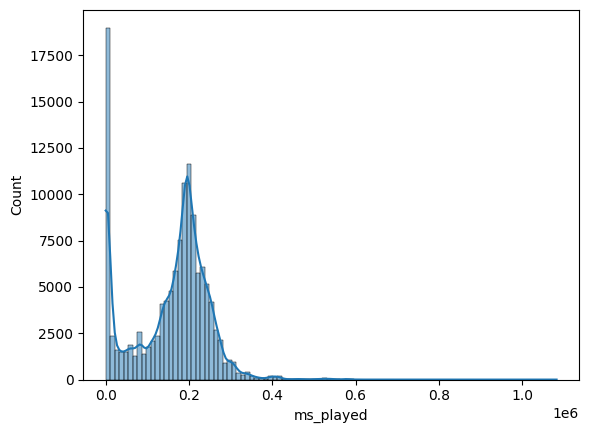

In [178]:
# histogram for ms_played rounded to nearest 1000 (in seconds) to see the distribution
sns.histplot(tracks_df['ms_played'].round(-3), kde = True, bins=100)

In [179]:
display(tracks_df[tracks_df['ms_played'] == 0].sample(5))
print(tracks_df[tracks_df['ms_played'] == 0].shape)

,ts,platform,ms_played,conn_country,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,spotify_track_uri,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
3247,2017-03-24T13:18:38Z,"Android OS 7.0 API 24 (Sony, E6683)",0,ID,Inside (feat. Danyka Nadeau),Au5,Monstercat 023 - Voyage,spotify:track:204PudWeSLHxVwOkune8mr,NaN,NaN,NaN,backbtn,NaN,True,NaN,False,1490361516943,False
46244,2019-06-15T07:56:19Z,"Android OS 9 API 28 (OnePlus, ONEPLUS A5010)",0,JP,"Row - From ""Eternal Sunshine of the Spotless M...",Jon Brion,Eternal Sunshine Of The Spotless Mind,spotify:track:1MAeLzBF3xsg6fpRZztyCD,NaN,NaN,NaN,trackdone,fwdbtn,True,NaN,False,1560585377559,False
11165,2017-09-22T12:18:15Z,"Android OS 7.1.1 API 25 (Sony, E6683)",0,ID,Castle on the Hill,Ed Sheeran,÷,spotify:track:6PCUP3dWmTjcTtXY02oFdT,NaN,NaN,NaN,fwdbtn,NaN,True,NaN,False,1506082693692,False
58070,2020-05-10T03:45:15Z,"Android OS 9 API 28 (OnePlus, ONEPLUS A5010)",0,JP,LONELY,Bishop Briggs,CHAMPION,spotify:track:1GGxW9kSgEtr7QgjCpP1U5,NaN,NaN,NaN,fwdbtn,fwdbtn,True,NaN,False,1589082312216,False
88569,2021-12-14T18:42:20Z,"Android OS 11 API 30 (OnePlus, HD1910)",0,JP,Rambling Rose,THREE1989,KISS,spotify:track:3oEYT3sty2KeJL0geWPRTu,NaN,NaN,NaN,fwdbtn,fwdbtn,True,NaN,False,1639507337652,False


(3755, 18)


there are surprisingly a lot of rows with 0 ms_played, might need to check it later

In [181]:
# checking platform unique values
tracks_df['platform'].value_counts()

platform
Android OS 11 API 30 (OnePlus, HD1910)                       21563
android                                                      19404
Android OS 9 API 28 (OnePlus, ONEPLUS A5010)                 15578
Android OS 10 API 29 (OnePlus, ONEPLUS A5010)                15124
Android OS 8.1.0 API 27 (OnePlus, ONEPLUS A5010)             10919
Windows 10 (10.0.17134; x64)                                  7099
Android OS 7.1.1 API 25 (Sony, E6683)                         6847
Windows 10 (10.0.14393; x64)                                  6764
Windows 10 (10.0.18363; x64)                                  6702
Android OS 7.0 API 24 (Sony, E6683)                           4074
windows                                                       3136
Windows 10 (10.0.18362; x64)                                  2858
Android OS 8.0.0 API 26 (OnePlus, ONEPLUS A5010)              1049
Windows 10 (10.0.16299; x64)                                  1011
Android OS 6.0.1 API 23 (Sony, E6683)                

in hindsight, it seems there are just 3 unique values in platform column (android, windows, web_player), we need to handle this value

based on what we've seen, there are some things that we need to handle:
- drop podcasts related columns
- drop offline_timestamp column
- drop conn_country column since I think what _platform_ the track was streamed is more important than the _country_ it was streamed
- drop incognito_mode column
- convert 'ts' column into datetime datatype
- rename columns with long label (master_metadata_artist_name, etc) into shorter form
- trim spotify_track_uri to only track ids
- handle _platform_ into three values (web_player, android, windows)
- take a look on rows with 0 ms_played 

## Data Preprocessing

### dropping unimportant columns

In [182]:
# dropping the columns that are not useful
tracks_df.drop(columns=['conn_country', 'offline_timestamp', 'episode_name', 'episode_show_name', 'spotify_episode_uri'], inplace=True)


In [198]:
tracks_df.drop(columns=['incognito_mode'], inplace=True)

### converting 'ts' column to datetime datatype

In [183]:
# converting 'ts' to datetime format
tracks_df['ts'] = pd.to_datetime(tracks_df['ts'])

### renaming columns with long label

In [186]:
# renaming master_metadata_track_name, master_metadata_album_artist_name, and master_metadata_album_album_name into track_name, artist_name, and album_name
tracks_df.rename(columns={'master_metadata_track_name':'track_name', 'master_metadata_album_artist_name':'artist_name', 'master_metadata_album_album_name':'album_name'}, inplace=True)

In [187]:
tracks_df.sample(5)

,ts,platform,ms_played,track_name,artist_name,album_name,spotify_track_uri,reason_start,reason_end,shuffle,skipped,offline,incognito_mode
37631,2019-01-08 17:30:18+00:00,Windows 10 (10.0.17134; x64),201253,Baby - Acoustic,Bishop Briggs,Baby,spotify:track:65Wza2OBkKGIW17fome7pk,trackdone,trackdone,True,NaN,False,False
117674,2023-05-23 02:50:47+00:00,android,184273,Wild World,Scary Pockets,Funk Box,spotify:track:1lcOlGIVfGB36aeheTC3GN,clickrow,trackdone,True,False,False,False
108179,2022-12-13 07:39:58+00:00,android,208092,Hate Myself,dodie,Build A Problem,spotify:track:4ILUKveMdxak81RIB0iyhH,trackdone,trackdone,True,0.0,False,False
78647,2021-06-19 22:42:00+00:00,"Android OS 10 API 29 (OnePlus, ONEPLUS A5010)",666,City Lounge,Saib,City Lounge,spotify:track:1hxcBxHHWA57B1xiDPZpNs,fwdbtn,fwdbtn,True,NaN,False,False
109832,2023-01-17 10:41:26+00:00,android,1502,Hate Myself (Voice Memo),dodie,Hate Myself (Voice Memo),spotify:track:5op5f1pZvU7Vj0KDSYSYdK,fwdbtn,fwdbtn,True,1.0,False,False


### handling platform columns

In [188]:
tracks_df['platform'].value_counts()

platform
Android OS 11 API 30 (OnePlus, HD1910)                       21563
android                                                      19404
Android OS 9 API 28 (OnePlus, ONEPLUS A5010)                 15578
Android OS 10 API 29 (OnePlus, ONEPLUS A5010)                15124
Android OS 8.1.0 API 27 (OnePlus, ONEPLUS A5010)             10919
Windows 10 (10.0.17134; x64)                                  7099
Android OS 7.1.1 API 25 (Sony, E6683)                         6847
Windows 10 (10.0.14393; x64)                                  6764
Windows 10 (10.0.18363; x64)                                  6702
Android OS 7.0 API 24 (Sony, E6683)                           4074
windows                                                       3136
Windows 10 (10.0.18362; x64)                                  2858
Android OS 8.0.0 API 26 (OnePlus, ONEPLUS A5010)              1049
Windows 10 (10.0.16299; x64)                                  1011
Android OS 6.0.1 API 23 (Sony, E6683)                

In [189]:
# trim the platform values to only the first word and make it lowercase
tracks_df['platform'] = tracks_df['platform'].str.split().str[0].str.lower()

In [191]:
# replace 'partner' value in platform column with 'web_player'
tracks_df['platform'].replace('partner', 'web_player', inplace=True)

In [192]:
tracks_df['platform'].value_counts()

platform
android       95925
windows       31959
web_player       77
Name: count, dtype: int64

### handling spotify_track_uri to only track_id

In [195]:
# trim spotify_track_uri to only the track id and rename the column into track_id
tracks_df['spotify_track_uri'] = tracks_df['spotify_track_uri'].str.split(':').str[2]
tracks_df.rename(columns={'spotify_track_uri':'track_id'}, inplace=True)

In [199]:
tracks_df.sample(5)

,ts,platform,ms_played,track_name,artist_name,album_name,track_id,reason_start,reason_end,shuffle,skipped,offline
112914,2023-03-05 05:08:01+00:00,android,202435,Got Weird,dodie,Hot Mess,3sTZqO3R6OT1SSScoaL1U6,trackdone,trackdone,True,False,False
63129,2020-08-05 04:20:44+00:00,android,56646,In Hell I'll Be in Good Company,The Dead South,Good Company,4eMxLQtSdgxdA1Hs6D2YuN,fwdbtn,fwdbtn,False,NaN,False
110686,2023-01-28 11:16:03+00:00,android,124415,Words Ain't Enough,Tessa Violet,Words Ain't Enough,7lMzNAybmy1UNPsgflbVcE,trackdone,trackdone,True,False,False
65860,2020-09-12 12:50:25+00:00,windows,197005,Fast Slow Disco,St. Vincent,Fast Slow Disco,6Xk5AaN4n4SnW71473GI7A,trackdone,trackdone,False,NaN,False
93821,2022-04-14 05:31:22+00:00,windows,189267,High Water,Bishop Briggs,High Water / Art of Survival,0ZrHaA9ei55Km65yBodElf,trackdone,trackdone,True,NaN,False


In [200]:
#save tracks_df into csv
tracks_df.to_csv('datasets/tracks_df_processed.csv', index=False)